In [73]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import pytensor as pt
import arviz as az


In [2]:
data = pd.read_csv('statcast_data/2023.csv')

In [62]:
def add_sz_plate(ax):
    # add home plate to plot 
    home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
    ax.add_patch(patches.Polygon(home_plate_coords,
                                    edgecolor = 'darkgray',
                                    facecolor = 'lightgray',
                                    zorder = 2))

    # add strike zone to plot, technically the y coords can vary by batter
    ax.add_patch(patches.Rectangle((-0.71, 1.5), 2*0.71, 2,
                    edgecolor = 'lightgray',
                    fill=False,
                    lw=3,
                    zorder = 2))
    return ax

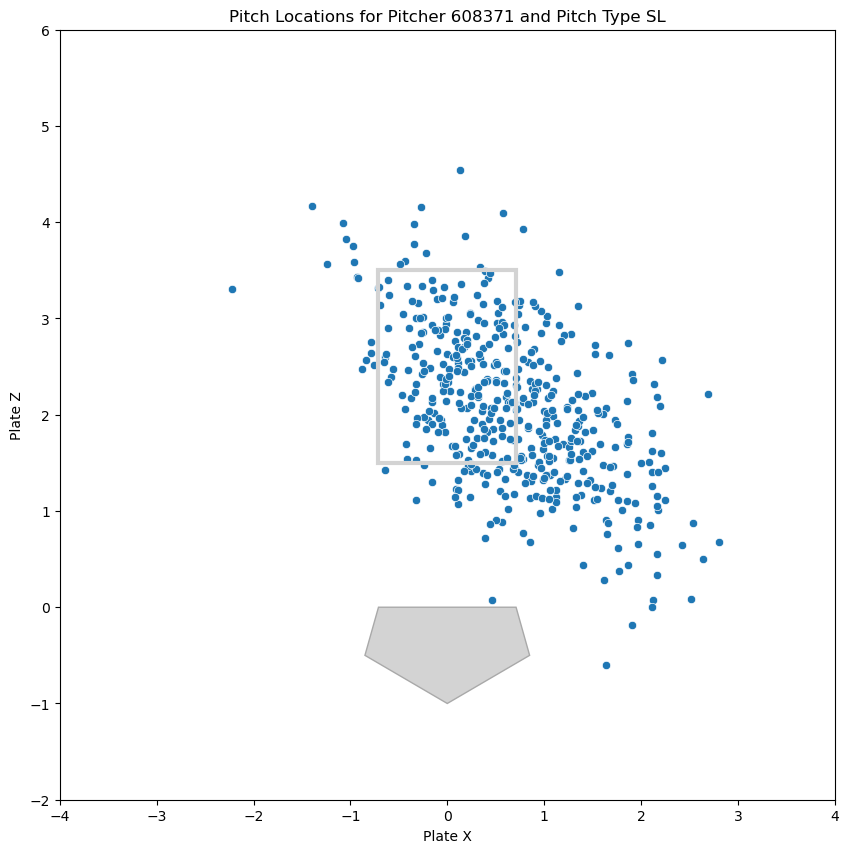

In [63]:
# Filter data for Lucas Sims and SL
sims_data = data[(data['pitcher'] == 608371) & (data['pitch_type'] == 'SL')]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=sims_data, x='plate_x', y='plate_z', ax=ax)
plt.title('Pitch Locations for Lucas Sims SL')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.xlim(-4, 4)
plt.ylim(-2, 6)

# add home plate to plot 
ax = add_sz_plate(ax)
plt.show()


In [4]:
called_strikes_balls = data.loc[data['description'].isin(['ball', 'called_strike'])]

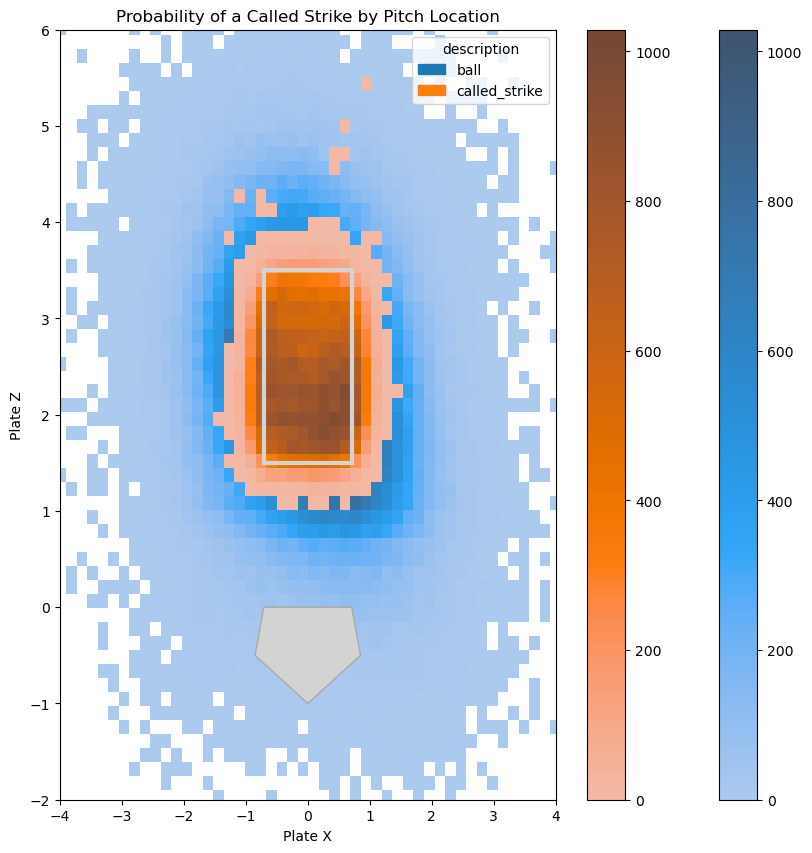

In [64]:
from matplotlib import patches
# Assuming 'description' is a column where 'called_strike' indicates a strike
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=called_strikes_balls, x='plate_x', y='plate_z', hue='description', bins=100, cbar=True, ax = ax)
plt.title('Probability of a Called Strike by Pitch Location')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.xlim(-4, 4)
plt.ylim(-2, 6)

# add home plate to plot
ax = add_sz_plate(ax)
plt.show()

In [9]:
pitcher_counts = data['pitcher'].value_counts()
data = data[data['pitcher'].isin(pitcher_counts[pitcher_counts > 100].index)]
data = data.loc[data['pitch_type'].isin(['SL'])]

In [10]:
len(data)

108134

In [11]:
data['stand'] = (data['stand'] == 'L').astype(int)
data['p_throws'] = (data['p_throws'] == 'L').astype(int)

In [12]:
num_pitchers = data['pitcher'].nunique()

In [13]:
data = data[['pitcher', 'plate_x', 'plate_z', 'stand', 'p_throws', 'pitch_type', 'balls', 'strikes']]
data.head()


,pitcher,plate_x,plate_z,stand,p_throws,pitch_type,balls,strikes
2,641360,0.12,3.22,0,0,SL,0,0
53,640451,2.62,-0.57,0,0,SL,0,0
74,676130,0.04,2.75,0,0,SL,1,1
76,676130,1.49,0.37,0,0,SL,0,0
80,666168,-0.08,3.09,1,0,SL,1,2


In [14]:
data = data.dropna()

In [15]:
pitcher_categories = data['pitcher'].astype('category')
pitcher_idx = pitcher_categories.cat.codes.values
pitcher_id_to_idx = {id: idx for idx, id in enumerate(pitcher_categories.cat.categories)}
stand = data['stand'].values
p_throws = data['p_throws'].values
balls = data['balls'].values
strikes = data['strikes'].values
observed_x = data['plate_x'].values
observed_z = data['plate_z'].values
obs_sd_x = np.std(observed_x)
obs_sd_z = np.std(observed_z)


In [50]:
print(observed_x.mean(), observed_z.mean(), obs_sd_x, obs_sd_z)

0.22409179235680576 1.8851121495327103 0.8776745733463057 0.9081428278973837


In [51]:
np.cov(observed_x, observed_z)

array([[ 0.77031978, -0.17003741],
       [-0.17003741,  0.82473103]])

In [84]:
df = pd.read_csv('statcast_data/2023.csv')
df = df.dropna(subset=['pitcher', 'pitch_type', 'plate_x', 'plate_z', 'stand', 'p_throws', 'balls', 'strikes'])

In [85]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
pitcher_encoder = LabelEncoder()
pitch_type_encoder = LabelEncoder()
p_throws_encoder = LabelEncoder()
stand_encoder = LabelEncoder()

# Encode categorical variables
df['pitcher_encoded'] = pitcher_encoder.fit_transform(df['pitcher'])
df['pitch_type_encoded'] = pitch_type_encoder.fit_transform(df['pitch_type'])
df['p_throws_encoded'] = p_throws_encoder.fit_transform(df['p_throws'])
df['stand_encoded'] = stand_encoder.fit_transform(df['stand'])

In [92]:
# Data preparation
observed_plate_x = df['plate_x'].values # horizontal location of pitch
observed_plate_z = df['plate_z'].values # vertical location of pitch
pitcher_data = df['pitcher_encoded'].values # pitcher id
pitch_type_data = df['pitch_type_encoded'].values # pitch type
p_throws_data = df['p_throws_encoded'].values # pitcher handedness
stand_data = df['stand_encoded'].values # batter handedness
balls_data = df['balls'].values # number of balls
strikes_data = df['strikes'].values # number of strikes

# Number of unique categories for each variable
n_pitchers = len(df['pitcher_encoded'].unique())
n_pitch_types = len(df['pitch_type_encoded'].unique())
n_p_throws = len(df['p_throws_encoded'].unique())
n_stand = len(df['stand_encoded'].unique())
n_balls = len(df['balls'].unique())
n_strikes = len(df['strikes'].unique())

# # Initialize the model
# with pm.Model() as hierarchical_model:
#     # Hyperpriors for global mean and covariance matrix
#     global_mu = pm.Normal('global_mu', mu=0., sigma=10., shape=2)
#     chol_packed = pm.LKJCholeskyCov('chol_packed', n=2, eta=2., sd_dist=pm.Exponential.dist(1.0), shape=3, compute_corr=False)
#     chol = pm.expand_packed_triangular(2, chol_packed)
#     cov = np.dot(chol, chol.T)
    
#     # Pitcher-level deviations
#     pitcher_mu = pm.Normal('pitcher_mu', mu=0., sigma=1., shape=(n_pitchers, 2))
#     pitcher_chol = pm.LKJCholeskyCov('pitcher_chol', n=2, eta=2., sd_dist=pm.Exponential.dist(1.0), shape=3, compute_corr=False)
    
#     # Context deviations
#     condition_mu = pm.Normal('condition_mu', mu=0., sigma=1., shape=(n_pitch_types, n_p_throws, n_stand, n_balls, n_strikes, 2))
    
#     # Combine global, pitcher and condition means
#     mu_combined = global_mu + pitcher_mu[pitcher_data] + condition_mu[pitch_type_data, p_throws_data, stand_data, balls_data, strikes_data]
    
#     # Likelihood
#     obs = pm.MvNormal('obs', mu=mu_combined, chol=chol, observed=np.stack([observed_plate_x, observed_plate_z], axis=1))

In [93]:
with hierarchical_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [global_mu, chol_packed, pitcher_mu, pitcher_chol, condition_mu]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 40356 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [125]:
# Initialize the model
with pm.Model() as hierarchical_model_2:
    # Hyperpriors for global mean
    global_mu = pm.Normal('global_mu', mu=0., sigma=10., shape=(n_pitch_types, n_p_throws, n_stand, n_balls, n_strikes, 2))
    
    # Pitcher-level deviations
    pitcher_mu = pm.Normal('pitcher_mu', mu=0., sigma=1., shape=(n_pitchers, n_pitch_types, n_p_throws, n_stand, n_balls, n_strikes, 2))
    
    # Combine global and pitcher means
    mu_combined = global_mu[pitch_type_data, p_throws_data, stand_data, balls_data, strikes_data] + \
                  pitcher_mu[pitcher_data, pitch_type_data, p_throws_data, stand_data, balls_data, strikes_data]
    
    # Hyperpriors for global covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=2, eta=2., sd_dist=pm.Exponential.dist(1.0), shape=3, compute_corr=False)
    chol = pm.expand_packed_triangular(2, chol_packed)
    cov = np.dot(chol, chol.T)
    
    # Likelihood
    obs = pm.MvNormal('obs', mu=mu_combined, chol=chol, observed=np.stack([observed_plate_x, observed_plate_z], axis=1))


In [126]:
with hierarchical_model_2:
    trace = pm.sample(500, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


MemoryError: Unable to allocate 18.9 GiB for an array with shape (1500, 827, 17, 2, 2, 5, 3, 2) and data type float64

In [94]:
az.summary(trace, var_names="~chol", round_to=2)

c:\Users\wampl\anaconda3\Lib\site-packages\arviz\utils.py:134: UserWarning: Items starting with ~: ['chol'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mu[0],-0.01,0.06,-0.11,0.10,0.02,0.01,12.34,33.71,1.18
global_mu[1],2.16,0.05,2.06,2.25,0.02,0.02,5.28,80.12,1.57
"pitcher_mu[0, 0]",0.06,0.04,-0.02,0.12,0.01,0.01,9.95,60.57,1.22
"pitcher_mu[0, 1]",-0.02,0.04,-0.09,0.05,0.01,0.01,9.57,148.70,1.26
"pitcher_mu[1, 0]",-0.03,0.04,-0.10,0.03,0.01,0.01,9.58,56.49,1.23
...,...,...,...,...,...,...,...,...,...
chol_packed[1],-0.16,0.00,-0.16,-0.16,0.00,0.00,8432.96,3275.13,1.00
chol_packed[2],0.82,0.00,0.82,0.82,0.00,0.00,7478.67,3686.48,1.00
pitcher_chol[0],1.00,1.01,0.00,2.87,0.02,0.01,3274.21,2181.49,1.00
pitcher_chol[1],-0.01,0.61,-1.29,1.15,0.01,0.01,4853.88,2680.65,1.00


c:\Users\wampl\anaconda3\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (3702) in plot_posterior, generating only 40 plots
  warnings.warn(
c:\Users\wampl\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'global_mu\n0'}>,
        <Axes: title={'center': 'global_mu\n1'}>,
        <Axes: title={'center': 'pitcher_mu\n0, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n0, 1'}>],
       [<Axes: title={'center': 'pitcher_mu\n1, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n1, 1'}>,
        <Axes: title={'center': 'pitcher_mu\n2, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n2, 1'}>],
       [<Axes: title={'center': 'pitcher_mu\n3, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n3, 1'}>,
        <Axes: title={'center': 'pitcher_mu\n4, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n4, 1'}>],
       [<Axes: title={'center': 'pitcher_mu\n5, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n5, 1'}>,
        <Axes: title={'center': 'pitcher_mu\n6, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n6, 1'}>],
       [<Axes: title={'center': 'pitcher_mu\n7, 0'}>,
        <Axes: title={'center': 'pitcher_mu\n7, 1'}>,
        <Axes: title={'center': 

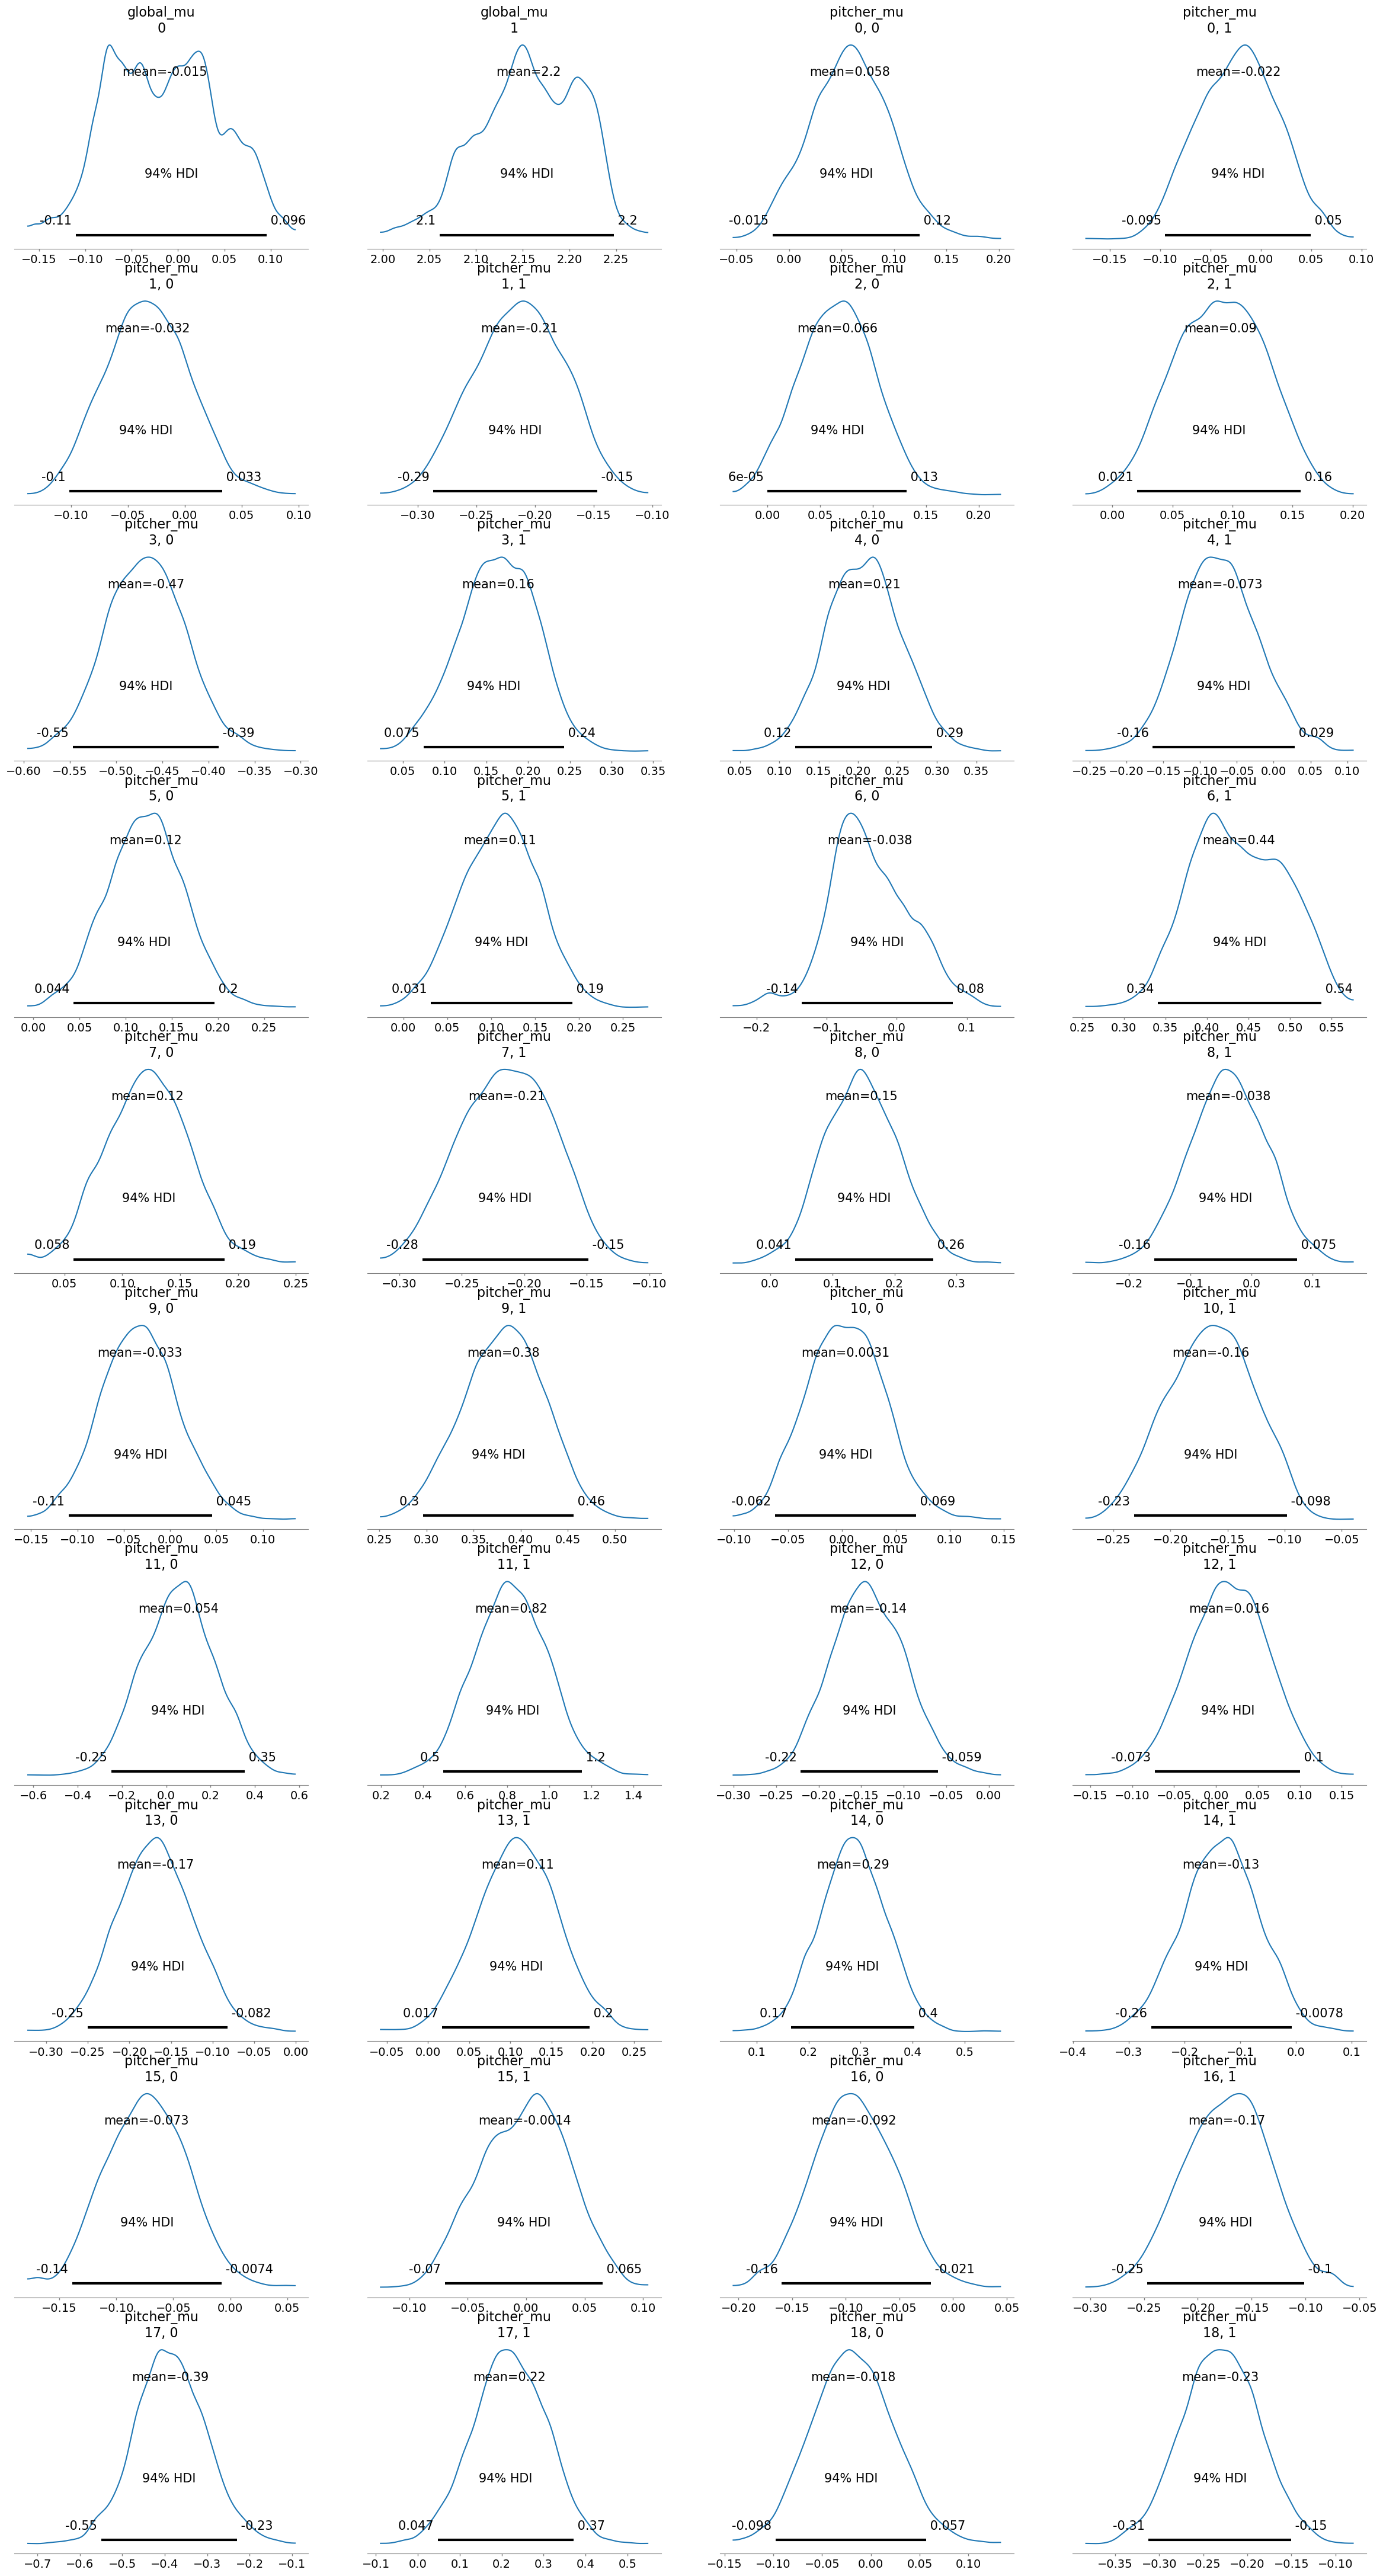

In [95]:
az.plot_posterior(trace)

In [98]:
pitcher_id_to_idx = {id: idx for idx, id in enumerate(pitcher_encoder.classes_)}
pitch_type_to_idx = {type: idx for idx, type in enumerate(pitch_type_encoder.classes_)}

In [113]:
specific_pitcher_idx = pitcher_id_to_idx[543037]

In [114]:
specific_pitch_type = pitch_type_to_idx['SL']

In [105]:
print(trace.posterior['condition_mu'].shape)

(3, 2000, 17, 2, 2, 5, 3, 2)


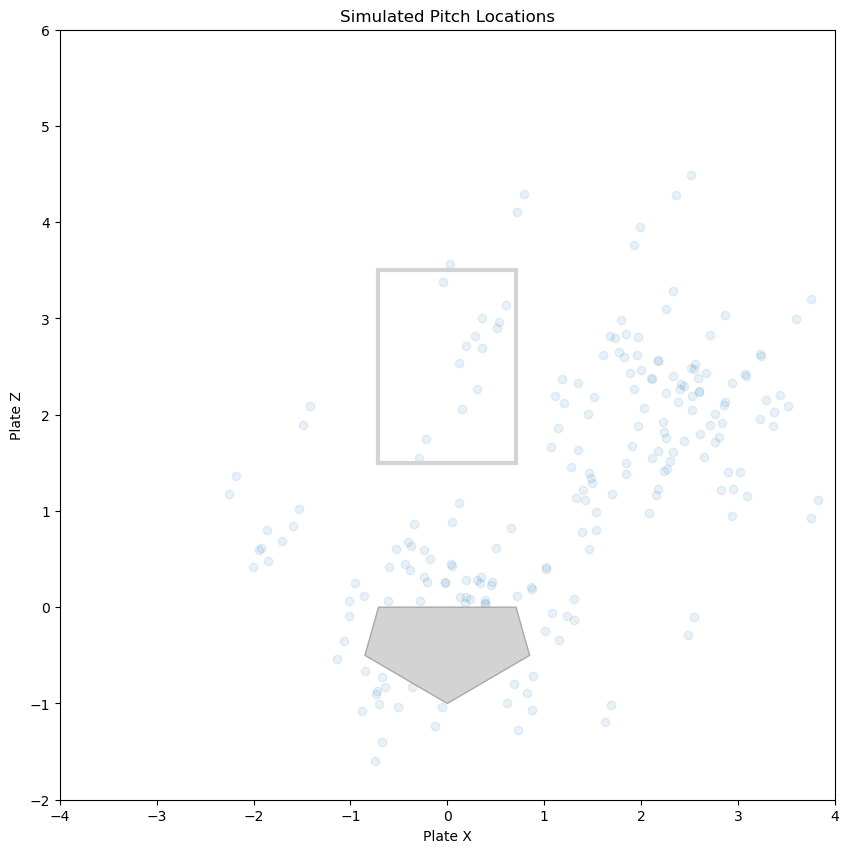

In [124]:
# Define the number of balls and strikes
num_balls = 0
num_strikes = 0

# Define the handedness of the batter and pitcher (0 for right-handed, 1 for left-handed)
batter_hand = 1
pitcher_hand = 1

# Extract the relevant samples from the posterior
simulated_x = trace.posterior['global_mu'][:, 0] + trace.posterior['pitcher_mu'][:, specific_pitcher_idx, 0] + trace.posterior['condition_mu'][:, specific_pitch_type, 1, 1, :, :, 0]
simulated_z = trace.posterior['global_mu'][:, 1] + trace.posterior['pitcher_mu'][:, specific_pitcher_idx, 1] + trace.posterior['condition_mu'][:, specific_pitch_type, 1, 1, :, :, 1]

# Plot the simulated pitch locations
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(simulated_x, simulated_z, alpha=0.1)
plt.title('Simulated Pitch Locations')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.xlim(-4, 4)
plt.ylim(-2, 6)
ax = add_sz_plate(ax)
plt.show()

In [96]:
list(trace.posterior.variables)

['chain',
 'draw',
 'global_mu_dim_0',
 'global_mu',
 'pitcher_mu_dim_0',
 'pitcher_mu_dim_1',
 'pitcher_mu',
 'condition_mu_dim_0',
 'condition_mu_dim_1',
 'condition_mu_dim_2',
 'condition_mu_dim_3',
 'condition_mu_dim_4',
 'condition_mu_dim_5',
 'condition_mu',
 'chol_packed_dim_0',
 'chol_packed',
 'pitcher_chol_dim_0',
 'pitcher_chol']

In [78]:
simulated_x = trace.posterior['mu'].values[:, 0]
simulated_z = trace.posterior['mu'].values[:, 1]

In [80]:
simulated_x

array([[0.22128375, 1.88216613],
       [0.22498464, 1.88790529],
       [0.22588749, 1.88188684]])

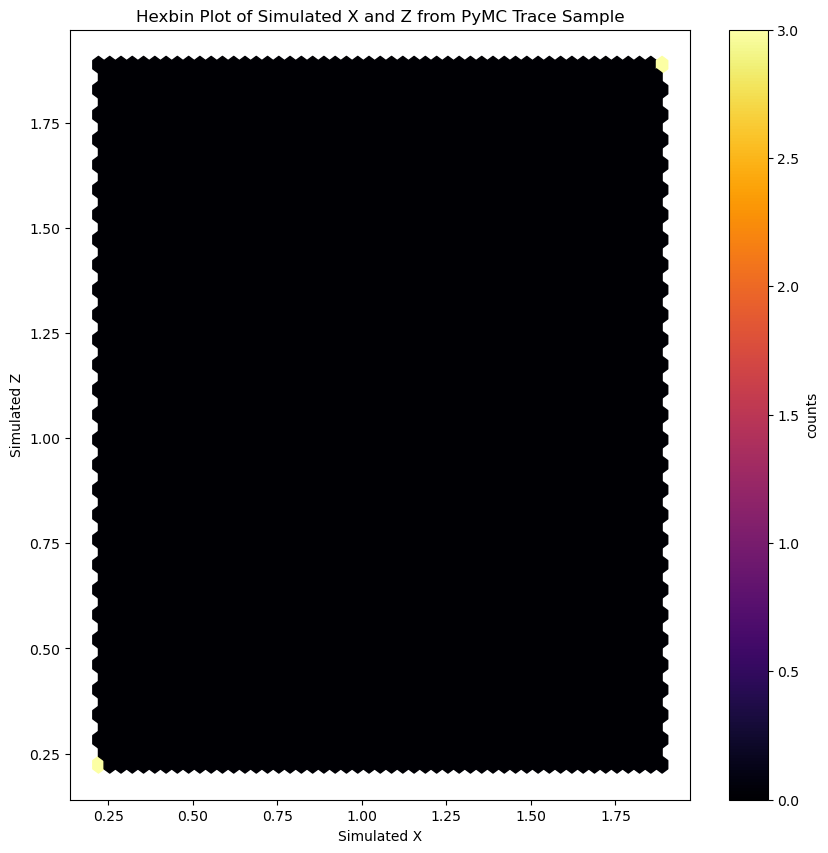

In [79]:

fig, ax = plt.subplots(figsize=(10, 10))
hb = ax.hexbin(simulated_x, simulated_z, gridsize=50, cmap='inferno')
cb = plt.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.title('Hexbin Plot of Simulated X and Z from PyMC Trace Sample')
plt.xlabel('Simulated X')
plt.ylabel('Simulated Z')
plt.show()






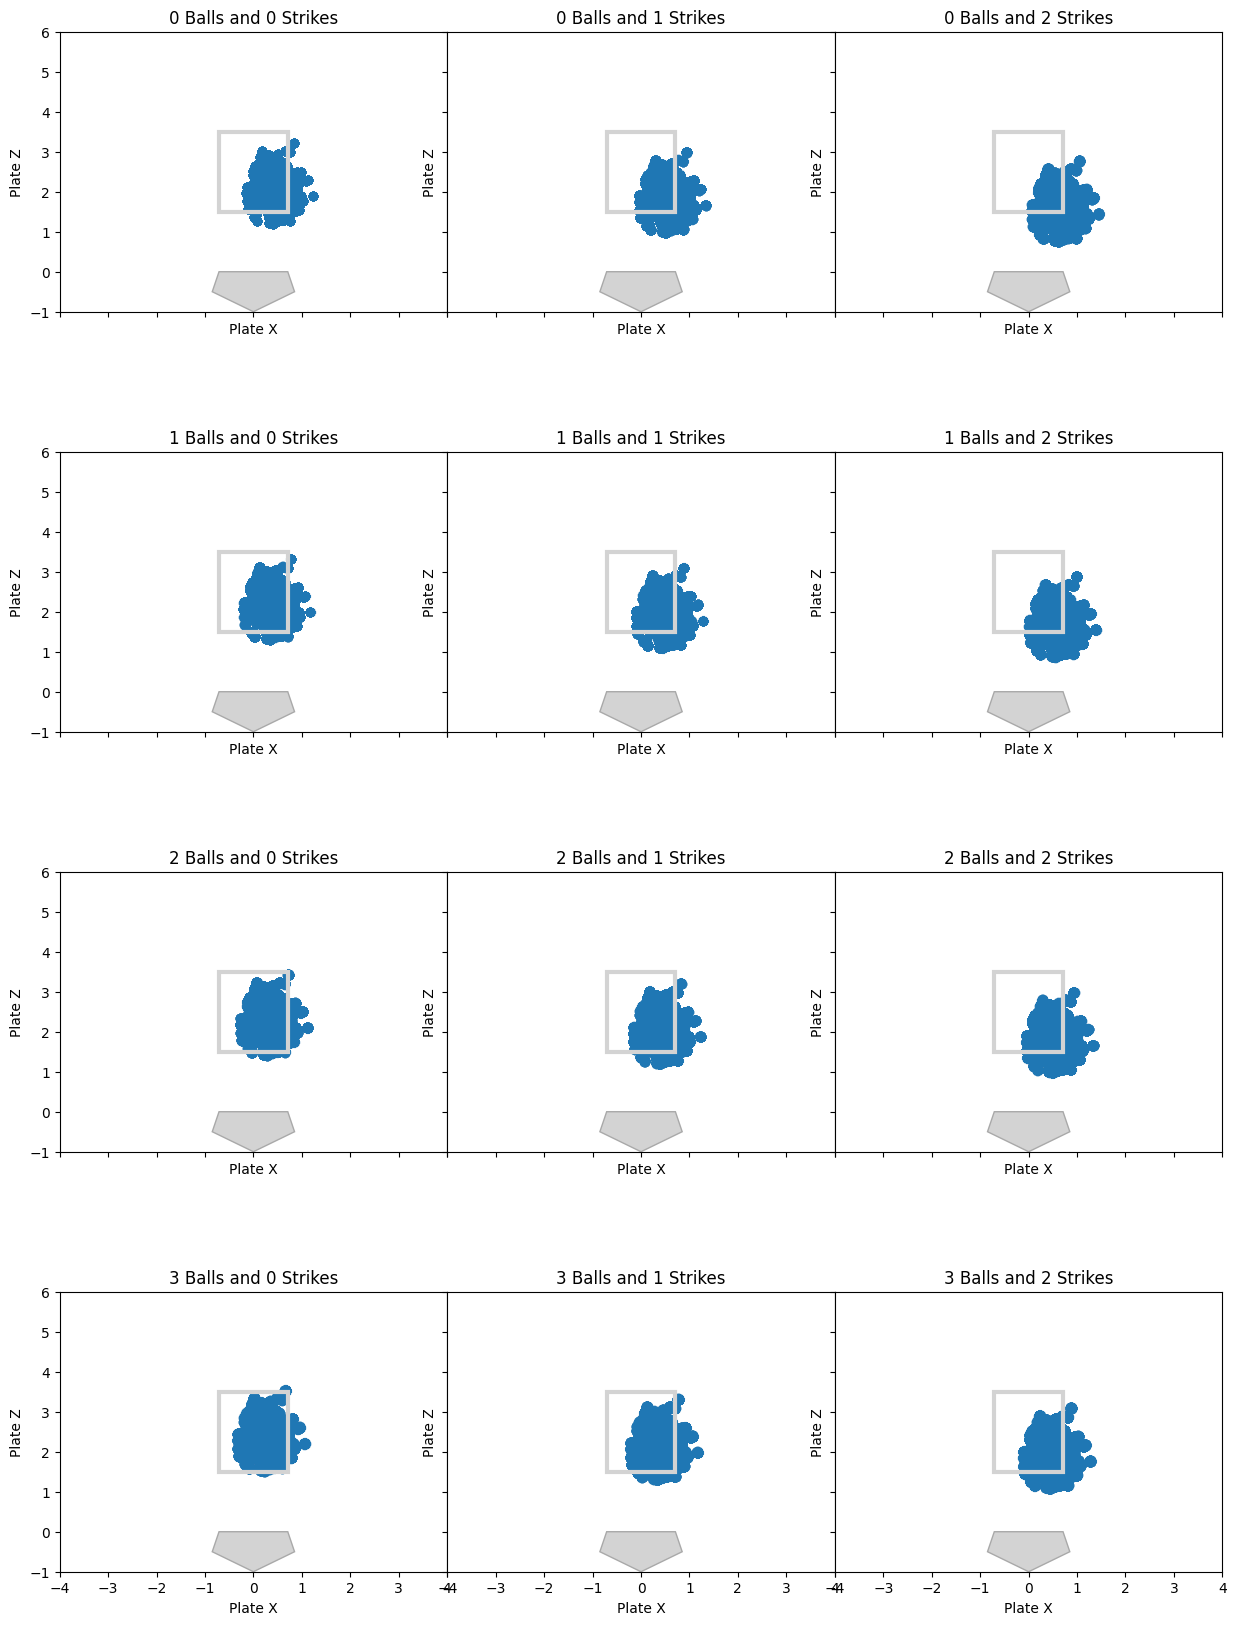

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharex=True, sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.001)
axs = axs.ravel()

home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]

for i in range(4):
    for j in range(3):
        simulated_x = trace.posterior['pitcher_mu_x'][:, specific_pitcher_idx] + trace.posterior['beta_balls_x'] * i + trace.posterior['beta_strikes_x'] * j \
            + trace.posterior['beta_stand_x'] * 0 + trace.posterior['beta_throw_x'] * 0
        simulated_z = trace.posterior['pitcher_mu_z'][:, specific_pitcher_idx] + trace.posterior['beta_balls_z'] * i + trace.posterior['beta_strikes_z'] * j \
            + trace.posterior['beta_stand_z'] * 0 + trace.posterior['beta_throw_z'] * 0
        axs[3*i+j].scatter(x=simulated_x, y=simulated_z, alpha=0.1)
        axs[3*i+j].set_title(f'{i} Balls and {j} Strikes')
        axs[3*i+j].set_xlabel('Plate X')
        axs[3*i+j].set_ylabel('Plate Z')

        # Add home plate to plot
        axs[3*i+j].add_patch(patches.Polygon(home_plate_coords,
                                edgecolor = 'darkgray',
                                facecolor = 'lightgray',
                                zorder = 2))

        # Add strike zone to plot
        axs[3*i+j].add_patch(patches.Rectangle((-0.71, 1.5), 2*0.71, 2,
                edgecolor = 'lightgray',
                fill=False,
                lw=3,
                zorder = 2))

plt.xlim(-4, 4)
plt.ylim(-1, 6)
plt.show()

In [ ]:
pitcher_id_to_idx[608371]

141